# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter. 

In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/assignment3"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/Your/assignment3/path/" $datadir # TODO: Fill your assignment3 path
os.chdir(datadir)
!pwd

# Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    # TODO: Implement rotate_img() - return the rotated img
    # 90 degrees
    # 180 degrees
    # 270 degrees
    elif rot == 1 or rot == 2 or rot == 3:
        return transforms.functional.rotate(img, rot * 90)
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Show some example images and rotated images with labels:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


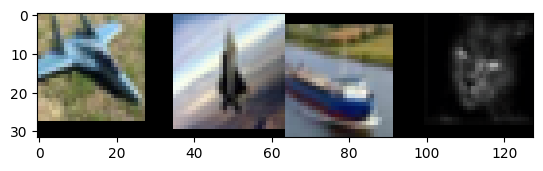

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


Class labels:  plane plane ship  cat  


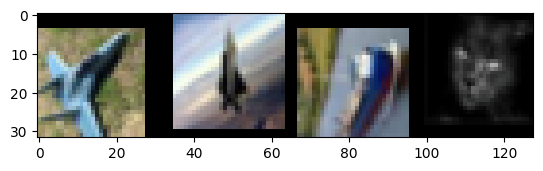

Rotation labels:  90    0     90    0    


In [3]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [4]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            outputs = net(images)
            _, lh = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (lh == labels).sum().item()
            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [5]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## 1. Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [79]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [80]:
import torch.optim as optim

# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters())

In [9]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
                images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                images, labels = imgs.to(device), cls_label.to(device)
            # TODO: Zero the parameter gradients
            # 0
            optimizer.zero_grad()
            # TODO: forward + backward + optimize
            net = net.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # TODO: Get predicted results
            _, predicted = torch.max(outputs.data, 1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        run_test(net, testloader, criterion, task)
        net.train()
    print('Finished Training')

In [81]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')

# TODO: Save the model
torch.save(net.state_dict(), 'resnet18_rotation.pth')

[1,   100] loss: 1.515 acc: 33.43 time: 1.59
[1,   200] loss: 1.258 acc: 43.05 time: 1.23
[1,   300] loss: 1.178 acc: 47.52 time: 1.20
TESTING:
Accuracy of the network on the 10000 test images: 48.79 %
Average loss on the 10000 test images: 1.223
[2,   100] loss: 1.120 acc: 51.29 time: 1.29
[2,   200] loss: 1.147 acc: 50.91 time: 1.21
[2,   300] loss: 1.100 acc: 53.11 time: 1.32
TESTING:
Accuracy of the network on the 10000 test images: 52.57 %
Average loss on the 10000 test images: 1.093
[3,   100] loss: 1.064 acc: 53.97 time: 1.33
[3,   200] loss: 1.043 acc: 55.34 time: 1.29
[3,   300] loss: 1.023 acc: 56.29 time: 1.42
TESTING:
Accuracy of the network on the 10000 test images: 58.58 %
Average loss on the 10000 test images: 1.001
[4,   100] loss: 1.011 acc: 56.79 time: 1.40
[4,   200] loss: 1.001 acc: 57.56 time: 1.29
[4,   300] loss: 0.965 acc: 59.03 time: 1.33
TESTING:
Accuracy of the network on the 10000 test images: 56.67 %
Average loss on the 10000 test images: 1.015
[5,   100] l

## 2.1 Fine-tuning on the pre-trained model

In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [257]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# TODO: Load the pre-trained ResNet18 model
net = resnet18(num_classes = 4).to(device)
net.load_state_dict(torch.load('resnet18_rotation.pth', map_location=device))
net.eval()
net.fc = nn.Linear(net.fc.in_features, len(classes))

In [258]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
for name, param in net.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False

In [259]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [260]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(params_to_update, lr = 0.005, weight_decay = 1e-6)

In [261]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
torch.save(net.state_dict(), 'resnet18_classification_ft.pth')

[1,   100] loss: 1.769 acc: 34.26 time: 1.56
[1,   200] loss: 1.501 acc: 44.36 time: 1.21
[1,   300] loss: 1.457 acc: 46.04 time: -0.72
TESTING:
Accuracy of the network on the 10000 test images: 50.90 %
Average loss on the 10000 test images: 1.360
[2,   100] loss: 1.394 acc: 49.46 time: 1.25
[2,   200] loss: 1.379 acc: 49.45 time: 1.19
[2,   300] loss: 1.369 acc: 50.18 time: 1.19
TESTING:
Accuracy of the network on the 10000 test images: 53.89 %
Average loss on the 10000 test images: 1.288
[3,   100] loss: 1.332 acc: 51.05 time: 1.27
[3,   200] loss: 1.330 acc: 51.47 time: 1.21
[3,   300] loss: 1.322 acc: 52.20 time: 1.20
TESTING:
Accuracy of the network on the 10000 test images: 54.49 %
Average loss on the 10000 test images: 1.268
[4,   100] loss: 1.313 acc: 52.40 time: 1.40
[4,   200] loss: 1.297 acc: 53.14 time: 1.30
[4,   300] loss: 1.303 acc: 52.39 time: 1.24
TESTING:
Accuracy of the network on the 10000 test images: 54.34 %
Average loss on the 10000 test images: 1.282
[5,   100] 

## 2.2 Fine-tuning on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [39]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
net = resnet18(num_classes = len(classes)).to(device)

In [40]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
for name, param in net.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False

In [41]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [42]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update)

In [43]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.290 acc: 24.05 time: 1.53
[1,   200] loss: 1.968 acc: 29.30 time: 1.17
[1,   300] loss: 1.906 acc: 31.13 time: 1.16
TESTING:
Accuracy of the network on the 10000 test images: 34.62 %
Average loss on the 10000 test images: 1.792
[2,   100] loss: 1.839 acc: 33.12 time: 1.21
[2,   200] loss: 1.831 acc: 34.23 time: 1.17
[2,   300] loss: 1.797 acc: 34.88 time: 1.15
TESTING:
Accuracy of the network on the 10000 test images: 38.30 %
Average loss on the 10000 test images: 1.718
[3,   100] loss: 1.786 acc: 35.55 time: 1.21
[3,   200] loss: 1.771 acc: 35.29 time: 1.12
[3,   300] loss: 1.774 acc: 35.85 time: 1.13
TESTING:
Accuracy of the network on the 10000 test images: 38.36 %
Average loss on the 10000 test images: 1.708
[4,   100] loss: 1.756 acc: 36.03 time: 1.20
[4,   200] loss: 1.759 acc: 36.18 time: 1.14
[4,   300] loss: 1.739 acc: 37.40 time: 1.14
TESTING:
Accuracy of the network on the 10000 test images: 39.23 %
Average loss on the 10000 test images: 1.687
[5,   100] l

## 3.1 Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [48]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
net = resnet18(num_classes = 4).to(device)
net.load_state_dict(torch.load('resnet18_rotation.pth', map_location=device))
net.eval()
net.fc = nn.Linear(net.fc.in_features, len(classes))

In [49]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr = 0.1)

In [50]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
torch.save(net.state_dict(), 'resnet18_classification_s.pth')

[1,   100] loss: 1.474 acc: 46.14 time: 1.68
[1,   200] loss: 1.182 acc: 57.84 time: 1.27
[1,   300] loss: 1.069 acc: 62.45 time: 1.29
TESTING:
Accuracy of the network on the 10000 test images: 63.10 %
Average loss on the 10000 test images: 1.076
[2,   100] loss: 0.943 acc: 67.02 time: 1.39
[2,   200] loss: 0.909 acc: 67.76 time: 1.28
[2,   300] loss: 0.888 acc: 69.29 time: 1.32
TESTING:
Accuracy of the network on the 10000 test images: 70.72 %
Average loss on the 10000 test images: 0.864
[3,   100] loss: 0.820 acc: 71.77 time: 1.36
[3,   200] loss: 0.824 acc: 71.10 time: 1.35
[3,   300] loss: 0.768 acc: 73.50 time: 1.31
TESTING:
Accuracy of the network on the 10000 test images: 71.03 %
Average loss on the 10000 test images: 0.839
[4,   100] loss: 0.740 acc: 74.56 time: 1.38
[4,   200] loss: 0.745 acc: 73.91 time: 1.31
[4,   300] loss: 0.746 acc: 74.05 time: 1.30
TESTING:
Accuracy of the network on the 10000 test images: 75.19 %
Average loss on the 10000 test images: 0.724
[5,   100] l

## 3.2 Supervised training on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [51]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
net = resnet18(num_classes = len(classes)).to(device)

In [52]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters())

In [53]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.193 acc: 23.01 time: 1.77
[1,   200] loss: 1.875 acc: 31.24 time: 1.33
[1,   300] loss: 1.749 acc: 35.48 time: 1.29
TESTING:
Accuracy of the network on the 10000 test images: 44.58 %
Average loss on the 10000 test images: 1.513
[2,   100] loss: 1.551 acc: 42.73 time: 1.36
[2,   200] loss: 1.566 acc: 42.92 time: 1.24
[2,   300] loss: 1.512 acc: 44.69 time: 1.28
TESTING:
Accuracy of the network on the 10000 test images: 35.78 %
Average loss on the 10000 test images: 4.069
[3,   100] loss: 1.355 acc: 50.34 time: 1.41
[3,   200] loss: 1.306 acc: 52.59 time: 1.34
[3,   300] loss: 1.249 acc: 55.09 time: 1.33
TESTING:
Accuracy of the network on the 10000 test images: 56.72 %
Average loss on the 10000 test images: 1.252
[4,   100] loss: 1.149 acc: 59.32 time: 1.24
[4,   200] loss: 1.113 acc: 60.30 time: 1.19
[4,   300] loss: 1.091 acc: 60.95 time: 1.31
TESTING:
Accuracy of the network on the 10000 test images: 65.43 %
Average loss on the 10000 test images: 0.978
[5,   100] l

## 4(a) Improved Rotation Prediction Model

In [268]:
net = resnet18(num_classes=4)
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters())

In [269]:
train(net, criterion, optimizer, num_epochs=60, decay_epochs=20, init_lr=0.005, task='rotation')
torch.save(net.state_dict(), 'resnet50_rotation.pth')

[1,   100] loss: 1.382 acc: 37.16 time: 1.82
[1,   200] loss: 1.184 acc: 47.41 time: 1.35
[1,   300] loss: 1.146 acc: 48.75 time: 1.35
TESTING:
Accuracy of the network on the 10000 test images: 51.89 %
Average loss on the 10000 test images: 1.135
[2,   100] loss: 1.141 acc: 50.24 time: -0.65
[2,   200] loss: 1.113 acc: 52.27 time: 1.24
[2,   300] loss: 1.066 acc: 53.63 time: 1.21
TESTING:
Accuracy of the network on the 10000 test images: 54.80 %
Average loss on the 10000 test images: 1.058
[3,   100] loss: 1.048 acc: 55.75 time: 1.33
[3,   200] loss: 1.033 acc: 56.05 time: 1.23
[3,   300] loss: 1.019 acc: 56.81 time: 1.30
TESTING:
Accuracy of the network on the 10000 test images: 59.36 %
Average loss on the 10000 test images: 0.957
[4,   100] loss: 0.990 acc: 58.29 time: 1.34
[4,   200] loss: 0.974 acc: 59.20 time: 1.26
[4,   300] loss: 0.970 acc: 59.59 time: 1.49
TESTING:
Accuracy of the network on the 10000 test images: 60.77 %
Average loss on the 10000 test images: 0.934
[5,   100] 

## 4(b) Improved Classification Prediction Model

In [271]:
net = resnet18(num_classes = 4).to(device)
net.load_state_dict(torch.load('resnet50_rotation.pth', map_location=device))
net.eval()
net.fc = nn.Linear(net.fc.in_features, len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr = 0.1)

In [272]:
train(net, criterion, optimizer, num_epochs=40, decay_epochs=15, init_lr=0.005, task='classification')
torch.save(net.state_dict(), 'resnet50_classification.pth')

[1,   100] loss: 1.461 acc: 46.47 time: 2.42
[1,   200] loss: 1.119 acc: 60.04 time: 1.66
[1,   300] loss: 0.988 acc: 64.51 time: 1.52
TESTING:
Accuracy of the network on the 10000 test images: 64.47 %
Average loss on the 10000 test images: 1.040
[2,   100] loss: 0.875 acc: 69.31 time: 1.39
[2,   200] loss: 0.853 acc: 70.28 time: 1.34
[2,   300] loss: 0.829 acc: 71.46 time: 1.36
TESTING:
Accuracy of the network on the 10000 test images: 73.58 %
Average loss on the 10000 test images: 0.769
[3,   100] loss: 0.775 acc: 73.05 time: 1.41
[3,   200] loss: 0.756 acc: 73.72 time: 1.33
[3,   300] loss: 0.746 acc: 74.48 time: 1.50
TESTING:
Accuracy of the network on the 10000 test images: 74.55 %
Average loss on the 10000 test images: 0.731
[4,   100] loss: 0.683 acc: 76.06 time: 1.39
[4,   200] loss: 0.700 acc: 75.68 time: 1.28
[4,   300] loss: 0.693 acc: 76.52 time: 1.28
TESTING:
Accuracy of the network on the 10000 test images: 75.04 %
Average loss on the 10000 test images: 0.732
[5,   100] l